### Imports

In [92]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm_notebook

import glob

import Levenshtein
from mid2names import import_fiw_names

from elasticsearch import Elasticsearch, helpers
from match_names import get_confidence
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport mid2names
%aimport match_names

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create LUTs

In [2]:
fiw_df = import_fiw_names('../FIW_DB_restructuring/fiwdb/FIDs')

100%|██████████| 978/978 [00:21<00:00, 45.58it/s]


In [3]:
fiw_df.head(2)

,source_db,fid,mid,gender,first,first_alias,last,last_alias,name
0,FIW,F0001,1,m,madmoud,,abbas,,madmoud abbas
1,FIW,F0001,2,f,amina,,abbas,,amina abbas


In [69]:
def create_msceleb_lut(path):
    
    ids, name = [], []
    f = open(path)
    for row in tqdm_notebook(f.readlines()):
        r = row.split('\t')
        ids.append(r[0])
        name.append(re.sub(r'\"(.*)\".*', r'\1', r[1][:-1])) 
    df = pd.DataFrame(columns=['source_db', 'id','name'])
    df['id'] = ids
    df['name'] = name
    df['source_db'] = 'msceleb'
    df['first'] = df.name.apply(lambda x:x.split()[0])
    df['last'] = df.name.apply(lambda x:x.split()[-1])
    return df

In [70]:
msceleb_df = create_msceleb_lut('../msceleb/name.en')

In [72]:
msceleb_df.head(2)

,source_db,id,name,first,last
0,msceleb,m.01008l47,Patrick Cummins,Patrick,Cummins
1,msceleb,m.01008l96,Mohamed Guessous,Mohamed,Guessous


In [4]:
import os

In [112]:
def create_vggface_lut(path):
    files = os.listdir(path)
    names= []
    for f in tqdm_notebook(files):
        n = f.replace('.txt', '').replace('_', ' ')
        names.append(n)
    df = pd.DataFrame(columns=['source_db', 'name', 'first', 'last'])
    df['name'] = names
    df['source_db'] = 'vggface'
    df['first'] = df.name.apply(lambda x:x.split()[0])
    df['last'] = df.name.apply(lambda x:x.split()[-1])
    return df

In [113]:
vggface_df = create_vggface_lut('../vgg_face_dataset/vgg_face_dataset/files/')

In [116]:
vggface_df.shape

(2622, 4)

In [136]:
def create_webface_lut(path):
    ids, name = [], []
    f = open(path)
    for row in tqdm_notebook(f.readlines()):
        r = row.split()
        ids.append(r[0])
        name.append(r[1].replace('_', ' ')) 
    df = pd.DataFrame(columns=['source_db', 'id','name'])
    df['id'] = ids
    df['name'] = name
    df['source_db'] = 'webface'
    df['first'] = df.name.apply(lambda x:x.split()[0])
    df['last'] = df.name.apply(lambda x:x.split()[-1])
    return df

In [137]:
webface_df = create_webface_lut('/home/rohit/Documents/NEU/SMILE/webface_id_name_list.txt')

In [141]:
webface_df.head(2)

,source_db,id,name,first,last
0,webface,0000045,Bruce Lee,Bruce,Lee
1,webface,0000099,Patricia Arquette,Patricia,Arquette


In [1]:
def create_celeba_lut(path):
    ids, name = [], []
    with open(path) as f:
        next(f)
        next(f)
        for row in f.readlines():
            r = row.split()
            ids.append(r[0])
            name.append(re.sub(r'_', r' ', r[1]))
        df = pd.DataFrame(columns=['source_db', 'id','name'])
        df['id'] = ids
        df['name'] = name
        df['source_db'] = 'msceleb'
        df['first'] = df.name.apply(lambda x:x.split()[0])
        df['last'] = df.name.apply(lambda x:x.split()[-1])
    return df

In [6]:
celeba_df = create_celeba_lut('../celebA/list_identity_celeba.txt')

### Index db2 in ES

In [7]:
es = Elasticsearch()

In [76]:
for i in tqdm_notebook(msceleb_df.index):
    name = msceleb_df.loc[i, "name"]
    doc = {'name':name}
    es.index(index='msceleb', doc_type='document', body=doc, id=i)

KeyboardInterrupt: 

In [119]:
# Index MS Celeb

docs = []
for i in tqdm_notebook(msceleb_df.index):
    name, _id = msceleb_df.loc[i, ["name", "id"]]
    docs.append({
                '_index':'msceleb',
                '_type':'document',
                '_id':_id,
                '_source':{'name':name}
            })
    if len(docs)==1000:
        helpers.bulk(es, docs)
        docs = []
if docs:
    helpers.bulk(es, docs)
    docs = []

KeyboardInterrupt: 

In [118]:
# Index VGG Face

docs = []
for i in tqdm_notebook(vggface_df.index):
    name, _id = vggface_df.loc[i, "name"], i
    docs.append({
                '_index':'vggface',
                '_type':'document',
                '_id':_id,
                '_source':{'name':name}
            })
    if len(docs)==1000:
        helpers.bulk(es, docs)
        docs = []
if docs:
    helpers.bulk(es, docs)
    docs = []

In [142]:
# Index Webface Face

docs = []
for i in tqdm_notebook(webface_df.index):
    name, _id = webface_df.loc[i, ["name", "id"]]
    docs.append({
                '_index':'webface',
                '_type':'document',
                '_id':_id,
                '_source':{'name':name}
            })
    if len(docs)==1000:
        helpers.bulk(es, docs)
        docs = []
if docs:
    helpers.bulk(es, docs)
    docs = []

In [8]:
celeba_df.head(2)

,source_db,id,name,first,last
0,msceleb,000001.jpg,Elizabeth Gutierrez,Elizabeth,Gutierrez
1,msceleb,000002.jpg,Emilia Fox,Emilia,Fox


In [11]:
# Index CelebA Face

docs = []
for i in tqdm_notebook(celeba_df.index):
    name, _id = celeba_df.loc[i, ["name", "id"]]
    docs.append({
                '_index':'celeba',
                '_type':'document',
                '_id':_id,
                '_source':{'name':name}
            })
    if len(docs)==1000:
        helpers.bulk(es, docs)
        docs = []
if docs:
    helpers.bulk(es, docs)
    docs = []

/home/rp/dev/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


### Find Overlap

In [16]:
overlap_df = pd.DataFrame(columns=['db1', 'db2', 'fid.mid', 'db2.id', 'name1', 'name2', 'confidence'])

for i in tqdm_notebook(fiw_df.index):
    first, last, gender, name, fid, mid = fiw_df.loc[i, ['first', 'last', 'gender', 'name', 'fid', 'mid']]
    body = {'query':{'bool':
                     {
                         'should':[{"match":{'name':first}}, {"match":{'name':last}}]
                     }
                    }}
    resp = es.search(index='celeba', body=body)['hits']['hits']
    for r in resp:
        name2 = r['_source']['name']
        conf = get_confidence(name, name2)
        if conf > 0.9:
            overlap_df.loc[len(overlap_df)] = 'fiw', 'celeba', f'{fid}.{mid}', r['_id'], name, name2, conf


/home/rp/dev/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
overlap_df['label'] = overlap_df.apply(lambda x:x['confidence']>=0.96, axis=1)

In [87]:
def get_celebA_images(name):
    indices = overlap_df.query(f'name2==@name').index
    
    fig, ax = plt.subplots(1, 7, figsize=(15, 15))
    path = '../celebA/img_align_celeba/'
    for i in range(7):
        img_name = overlap_df.loc[indices[i%len(indices)], 'db2.id']
        img = np.array(Image.open(path+img_name))
        ax[i].imshow(img)
    plt.show()
    
    return indices
        
    

In [98]:
for i in temp_celeba.index:
    fid_mid, db2_id, name1, name2 = temp_celeba.loc[i, ['fid.mid', 'db2.id', 'name1', 'name2']]
    fid, mid = fid_mid.split('.')
    display_images(f'../fiw_plus_vgg-cropped/{fid}/MID{mid}/')
    db2_indices = get_celebA_images(name2)
    print(name1)
    print(name2)
    if input()=='1':
        for j in db2_indices:
            overlap_df.loc[j, 'label'] = True
    clear_output()

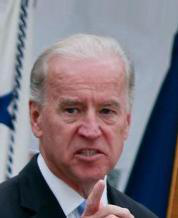

In [134]:
Image.open('../celebA/img_align_celeba/018726.jpg')

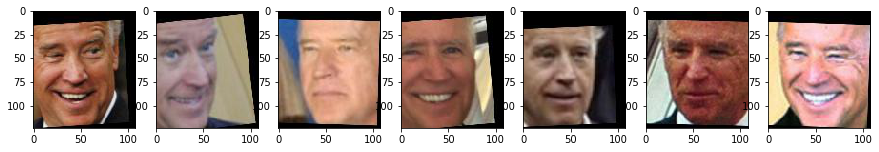

In [133]:
display_images('../fiw_plus_vgg-cropped/F0077/MID1/')

### Match Faces

In [39]:
def match_faces(img_dir1, img_dir2):
    features1_paths = glob.glob(f'{img_dir1}/P*.pkl')
    features2_paths = glob.glob(f'{img_dir2}/.mat')

In [40]:
from matplotlib import pyplot as plt

In [41]:
from PIL import Image

In [78]:
def display_images(path):
    if not os.path.isdir(path):
        path = re.sub(r'_(?!.*_)', r'__', path)
        if os.path.isdir(path):
            pass
        else:
            return None
        
    files = os.listdir(path)
    files = list(filter(lambda x:'jpg' in x, files))
    fig, ax = plt.subplots(1, 7, figsize=(15, 15))
    for i in range(7):
        img = np.array(Image.open(path+files[i%len(files)]))
        ax[i].imshow(img)
    plt.show()

In [50]:
from IPython.display import clear_output
import os

In [51]:
overlap_df['label'] = 0

In [55]:
for i in overlap_df.index:
    fid, mid, name1, name2, conf = overlap_df.loc[i, ['fid', 'mid', 'name1', 'name2', 'confidence']]
    img_dir1 = f'../fiw_plus_vgg-cropped/{fid}/MID{mid}/'
    display_images(img_dir1)
    img_dir2 = f101_df.query('name==@name2').iloc[0]['path'] + '/'
#     img_dir2 = f'../FIW_DB_restructuring/family_101/Family101_150x120/{name2_family_name}/{"_".join([x.capitalize() for x in name2.split()])}/'
    display_images(img_dir2)
    print(i, ': ', name1, '|', name2, '|', conf)
    label = input()
    if label=='1':
        overlap_df.loc[i, 'label'] = 1
    clear_output()

In [81]:
for i in overlap_df.index:
    overlap_df.loc[i, 'db2_imgdir_path'] = f101_df.loc[int(overlap_df.loc[i, 'db2.id']), 'path']

In [82]:
overlap_df[overlap_df.label==1]

,db1,db2,fid,mid,db2.id,name1,name2,confidence,label,db2_imgdir_path
0,fiw,family101,F0007,1,94,bhumibol adulyadej,bhumibol adulyadej,1,1,../FIW_DB_restructuring/family_101/Family101_1...
1,fiw,family101,F0040,2,616,mackenzie astin,mackenzie astin,1,1,../FIW_DB_restructuring/family_101/Family101_1...
2,fiw,family101,F0040,3,614,sean astin,sean astin,1,1,../FIW_DB_restructuring/family_101/Family101_1...
3,fiw,family101,F0040,4,617,john astin,john astin,1,1,../FIW_DB_restructuring/family_101/Family101_1...
4,fiw,family101,F0058,1,31,drew barrymore,drew blyth barrymore,0.94,1,../FIW_DB_restructuring/family_101/Family101_1...
...,...,...,...,...,...,...,...,...,...,...
145,fiw,family101,F0802,3,557,jessie wilson,jessie woodrow wilson,0.94,1,../FIW_DB_restructuring/family_101/Family101_1...
147,fiw,family101,F0802,5,560,margaret wilson,margaret woodrow wilson,0.94,1,../FIW_DB_restructuring/family_101/Family101_1...
148,fiw,family101,F0809,1,59,tiger woods,tiger woods,1,1,../FIW_DB_restructuring/family_101/Family101_1...
149,fiw,family101,F0809,5,58,kutilda woods,kultida woods,0.923077,1,../FIW_DB_restructuring/family_101/Family101_1...


In [90]:
x = overlap_df[overlap_df.label==1]

In [91]:
x['db2_imgdir_path'] = x.db2_imgdir_path.apply(lambda x: re.sub(r'.*FIW_DB_restructuring\/', '', x))


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
